In [2]:
import matplotlib.style
import numpy as np
from DP.utils import (
    fisher_gradient, 
    fisher_information_privatized, 
    is_epsilon_private, 
    binom_derivative,
    binom_optimal_privacy
)
from DP.linear_solver import LinearSolver
import cvxpy as cp
from scipy.stats import binom
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import FancyArrowPatch
matplotlib.style.use("bmh")


def project_onto_feasible_set(Q, epsilon):
    n_plus_1 = Q.shape[0]
    Q_var = cp.Variable((n_plus_1, n_plus_1))
    Q_param = Q

    # Objective: minimize ||Q_var - Q_param||_F^2
    objective = cp.Minimize(cp.norm(Q_var - Q_param, "fro"))

    # Constraints
    constraints = []

    # Non-negativity
    constraints += [Q_var >= 0]

    # Column sums
    for j in range(n_plus_1):
        constraints += [cp.sum(Q_var[:, j]) == 1]

    # ε-Differential Privacy constraints
    exp_eps = np.exp(epsilon)
    exp_neg_eps = np.exp(-epsilon)
    for i in range(n_plus_1):
        for j in range(n_plus_1):
            for j_prime in range(n_plus_1):
                if j < j_prime:
                    constraints += [Q_var[i, j] - exp_neg_eps * Q_var[i, j_prime] >= 0]
                    constraints += [exp_eps * Q_var[i, j_prime] - Q_var[i, j] >= 0]

    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)

    return Q_var.value


def projected_gradient_ascent(Q_init, p_theta, p_theta_dot, n, theta, epsilon):
    history = [Q_init]
    grads = list()
    fish = fisher_information_privatized(Q_init, n, theta)
    q = Q_init

    for i in range(100):
        grad_I = fisher_gradient(p_theta, p_theta_dot, q)
        # grad_I = grad_I / np.max(grad_I)
        # grad_I[-1, :] = 0
        q_raw = q + grad_I / np.sqrt(100 * (i + 1))
        
        if is_epsilon_private(q_raw, epsilon):
            q_new = q_raw
        else:
            history.append(q_raw)
            q_new = project_onto_feasible_set(q_raw, epsilon)

        fish_next = fisher_information_privatized(q_new, n, theta)

        if np.allclose(q, q_new):
            status = f"Converged after {i+1} iterations."
            break

        if abs(fish - fish_next) < 1e-8:
            status = f"Converged after {i+1} iteratons."
            break
        
        q = q_new
        fish = fish_next

        grads.append(grad_I)
        history.append(q)
        status = "Not converged"

    print(status)
    return history, grads

/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:104: RuntimeWarning: invalid value encountered in divide
  2 * np.outer(p_theta_dot, Q_ptheta_dot) / Q_ptheta
/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:105: RuntimeWarning: invalid value encountered in divide
  - np.outer(p_theta, Q_ptheta_dot_squared) / Q_ptheta_squared
/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:173: RuntimeWarning: invalid value encountered in divide
  return np.sum(numerator / denominator)


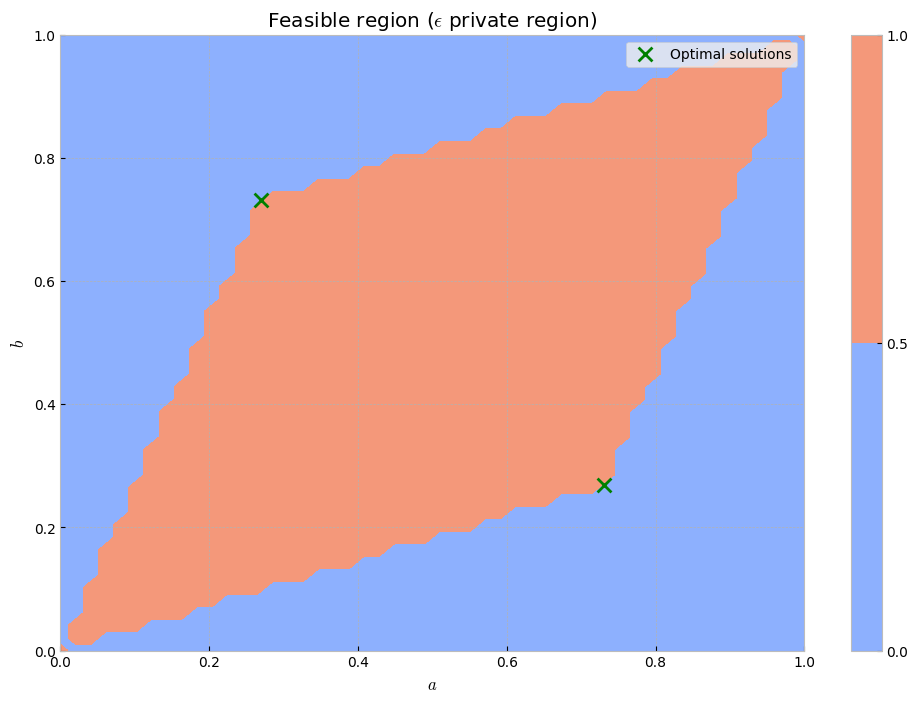

Converged after 6 iterations.


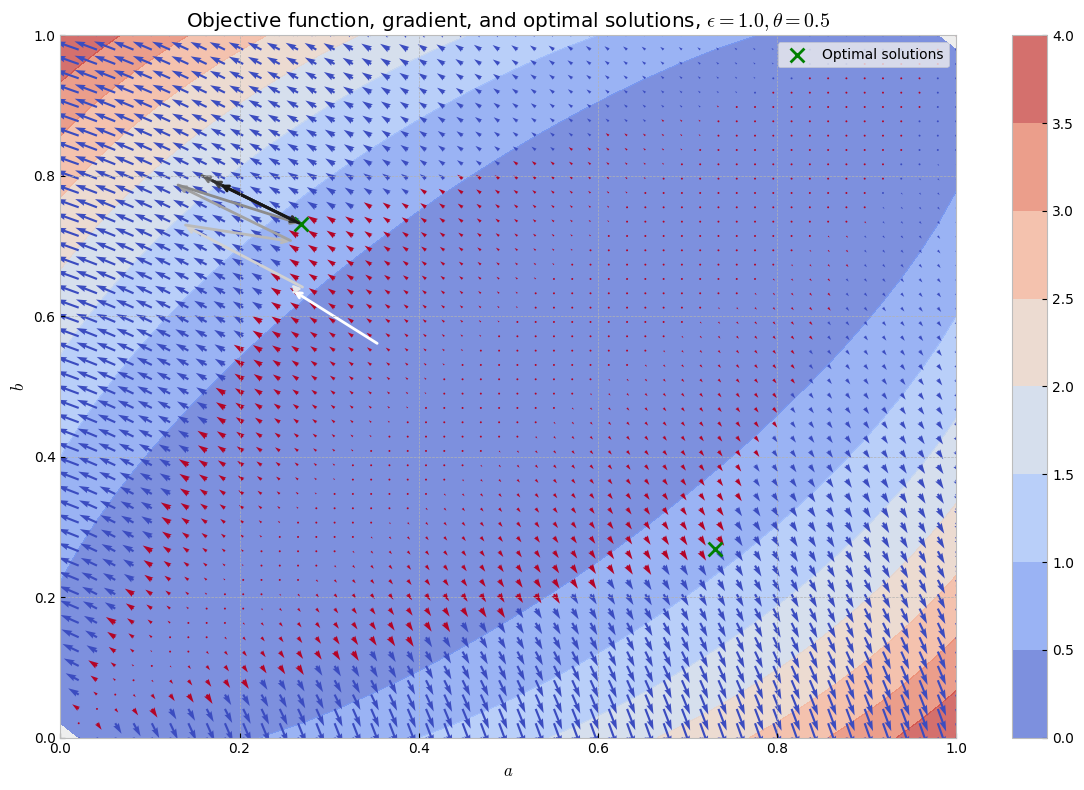

In [2]:
N = 1
THETA = 0.5
EPSILON = 1.0
NVALS = 50

p_theta = binom.pmf(np.arange(N + 1), N, THETA)
p_theta_dot = np.array([binom_derivative(i, N, THETA) for i in range(N + 1)])

a_vals = np.linspace(0, 1, NVALS)
b_vals = np.linspace(0, 1, NVALS)

grads_a = list()
grads_b = list()
private = list()
fishers = list()

for a in a_vals:
    for b in b_vals:
        q_mat = np.array([[a, b], [1-a, 1-b]])
        grad = fisher_gradient(p_theta, p_theta_dot, q_mat)

        fishers.append(fisher_information_privatized(q_mat, N, THETA))
        private.append(is_epsilon_private(q_mat, EPSILON))

        grads_a.append(grad[0, 0])
        grads_b.append(grad[0, 1])

grads_a = np.array(grads_a).reshape((NVALS, NVALS), order="F")
grads_b = np.array(grads_b).reshape((NVALS, NVALS), order="F")
private = np.array(private).reshape((NVALS, NVALS), order="F")
fishers = np.array(fishers).reshape((NVALS, NVALS), order="F")

opt_solutions, _, _ = binom_optimal_privacy(LinearSolver(), N, EPSILON, THETA)
xs = opt_solutions[:, 0]
ys = opt_solutions[:, 1]

# Feasible area plot
fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, private, cmap="coolwarm")
plt.colorbar()
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.title(r"Feasible region ($\epsilon$ private region)")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
plt.legend()
plt.show()


Q_init = np.ones((N + 1, N + 1)) / (N + 1) + np.random.normal(size=(N+1, N+1), scale=0.1)
Q_init = project_onto_feasible_set(Q_init, EPSILON)
history, grads = projected_gradient_ascent(Q_init, p_theta, p_theta_dot, N, THETA, EPSILON)
all_history = np.array(history)


# dense everything plot
from matplotlib.patches import FancyArrowPatch

colors = plt.cm.binary(np.linspace(0, 1, len(all_history)))

fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.7)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, private, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
#plt.scatter(all_history[:,0,0], all_history[:,0,1], marker="x", s=100, label="Sample path", c=colors)
for i in range(len(all_history) - 1):
    arrow = FancyArrowPatch((all_history[i,0,0], all_history[i,0,1]), (all_history[i+1,0,0], all_history[i+1,0,1]), 
                             color=colors[i], arrowstyle='->', mutation_scale=10, linewidth=2)
    ax.add_patch(arrow)
plt.legend()
plt.title(fr"Objective function, gradient, and optimal solutions, $\epsilon = {EPSILON}, \theta = {THETA}$")
plt.tight_layout()
plt.show()

/var/folders/lv/9hw1_pzj1hs5c2glqrzn04m80000gq/T/ipykernel_65041/3666026632.py:12: RuntimeWarning: invalid value encountered in scalar divide
  first = 2*p_theta_dot[j]*qpdot/qp
/var/folders/lv/9hw1_pzj1hs5c2glqrzn04m80000gq/T/ipykernel_65041/3666026632.py:13: RuntimeWarning: invalid value encountered in scalar divide
  second = p_theta[j]*qpdot2/qp2
/var/folders/lv/9hw1_pzj1hs5c2glqrzn04m80000gq/T/ipykernel_65041/3666026632.py:20: RuntimeWarning: invalid value encountered in scalar divide
  boundary_terms += 3*y**2/x**3 - long_coef*2*y/x**2 + long_coef/x
/var/folders/lv/9hw1_pzj1hs5c2glqrzn04m80000gq/T/ipykernel_65041/3666026632.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  boundary_terms += 3*y**2/x**3 - long_coef*2*y/x**2 + long_coef/x
/var/folders/lv/9hw1_pzj1hs5c2glqrzn04m80000gq/T/ipykernel_65041/3666026632.py:37: RuntimeWarning: invalid value encountered in scalar divide
  boundary_terms += (y/x - np.exp(-eps)) * (y/x - 1) * (y/x - np.exp(eps))
/var/folder

Converged after 22 iterations.


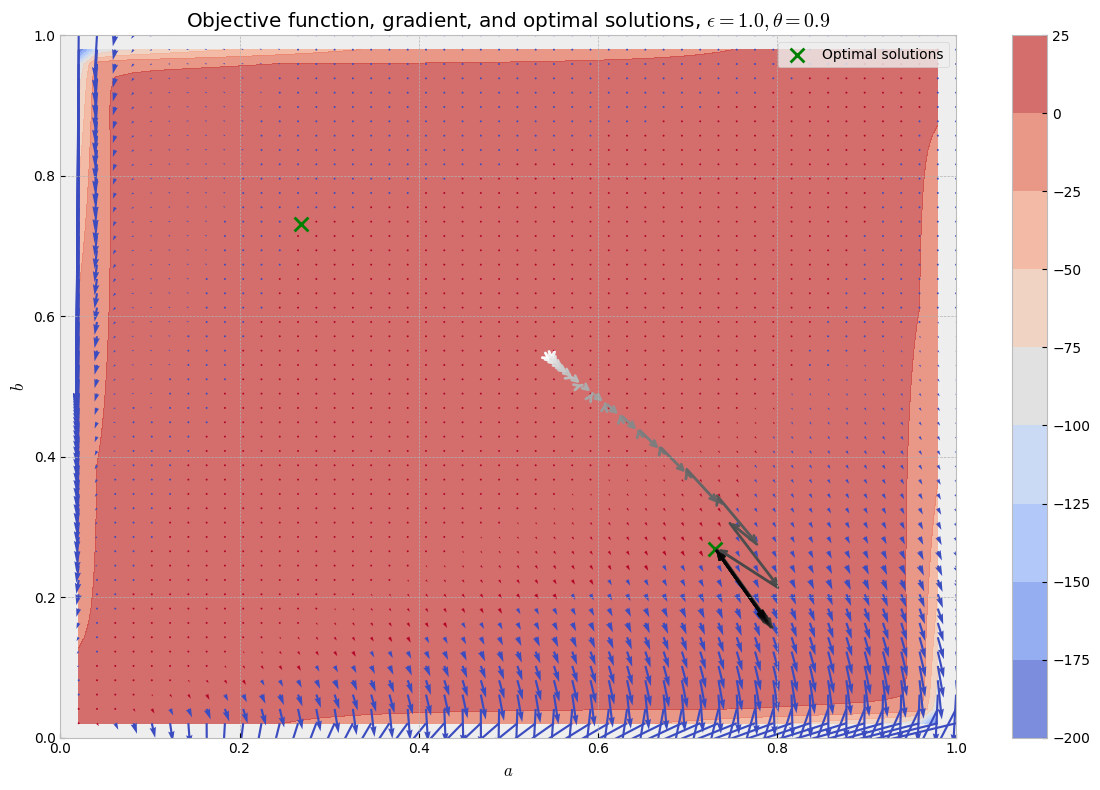

In [25]:
def fisher_gradient_modified(p_theta, p_theta_dot, q_mat, epsilon):
    grad = np.zeros(shape=q_mat.shape)

    long_coef = np.exp(-epsilon) + np.exp(epsilon) + 1
    for i in range(q_mat.shape[0]):
        for j in range(q_mat.shape[1]):
            qpdot = q_mat[i] @ p_theta_dot
            qp = q_mat[i] @ p_theta
            qpdot2 = qpdot**2
            qp2 = qp**2

            first = 2*p_theta_dot[j]*qpdot/qp
            second = p_theta[j]*qpdot2/qp2

            boundary_terms = 0
            for j_prime in range(q_mat.shape[1]):
                if j != j_prime:
                    y = q_mat[i,j]
                    x = q_mat[i,j_prime]
                    boundary_terms += 3*y**2/x**3 - long_coef*2*y/x**2 + long_coef/x
            grad[i, j] = first - second - 0.001 * boundary_terms
    return grad

def fisher_information_privatized_modified(Q, n, theta, eps):
    p_theta = binom.pmf(np.arange(n + 1), n, theta)
    p_theta_dot = [binom_derivative(i, n, theta) for i in range(n + 1)]

    numerator = np.power(Q @ p_theta_dot, 2)
    denominator = Q @ p_theta
    boundary_terms = 0
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            for j_prime in range(Q.shape[1]):
                if j != j_prime:
                    y = Q[i, j]
                    x = Q[i, j_prime]
                    boundary_terms += (y/x - np.exp(-eps)) * (y/x - 1) * (y/x - np.exp(eps))
    return np.sum(numerator / denominator) - 0.001 * boundary_terms

def projected_gradient_ascent_modified(Q_init, p_theta, p_theta_dot, n, theta, epsilon):
    history = [Q_init]
    grads = list()
    fish = fisher_information_privatized_modified(Q_init, n, theta, epsilon)
    q = Q_init

    for i in range(100):
        grad_I = fisher_gradient_modified(p_theta, p_theta_dot, q, epsilon)
        # grad_I = grad_I / np.max(grad_I)
        #grad_I[-1, :] = 0
        q_raw = q + grad_I / np.sqrt(100*(i + 1))
        
        if is_epsilon_private(q_raw, epsilon):
            q_new = q_raw
        else:
            history.append(q_raw)
            q_new = project_onto_feasible_set(q_raw, epsilon)

        fish_next = fisher_information_privatized_modified(q_new, n, theta, epsilon)

        if np.allclose(q, q_new):
            status = f"Converged after {i+1} iterations."
            break

        if abs(fish - fish_next) < 1e-6:
            status = f"Converged after {i+1} iteratons."
            break
        
        q = q_new
        fish = fish_next

        grads.append(grad_I)
        history.append(q)
        status = "Not converged"

    print(status)
    return history, grads

N = 1
THETA = 0.9
EPSILON = 1.0
NVALS = 50

p_theta = binom.pmf(np.arange(N + 1), N, THETA)
p_theta_dot = np.array([binom_derivative(i, N, THETA) for i in range(N + 1)])

a_vals = np.linspace(0, 1, NVALS)
b_vals = np.linspace(0, 1, NVALS)

grads_a = list()
grads_b = list()
private = list()
fishers = list()

for a in a_vals:
    for b in b_vals:
        q_mat = np.array([[a, b], [1-a, 1-b]])
        grad = fisher_gradient_modified(p_theta, p_theta_dot, q_mat, EPSILON)

        fishers.append(fisher_information_privatized_modified(q_mat, N, THETA, EPSILON))
        private.append(is_epsilon_private(q_mat, EPSILON))

        grads_a.append(grad[0, 0])
        grads_b.append(grad[0, 1])

grads_a = np.array(grads_a).reshape((NVALS, NVALS), order="F")
grads_b = np.array(grads_b).reshape((NVALS, NVALS), order="F")
private = np.array(private).reshape((NVALS, NVALS), order="F")
fishers = np.array(fishers).reshape((NVALS, NVALS), order="F")

opt_solutions, _, _ = binom_optimal_privacy(LinearSolver(), N, EPSILON, THETA)
xs = opt_solutions[:, 0]
ys = opt_solutions[:, 1]

Q_init = np.ones((N + 1, N + 1)) / (N + 1) + np.random.normal(size=(N+1, N+1), scale=0.1)
Q_init = project_onto_feasible_set(Q_init, EPSILON)
history, grads = projected_gradient_ascent_modified(Q_init, p_theta, p_theta_dot, N, THETA, EPSILON)
all_history = np.array(history)

colors = plt.cm.binary(np.linspace(0, 1, len(all_history)))

fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.7)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, private, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
#plt.scatter(all_history[:,0,0], all_history[:,0,1], marker="x", s=100, label="Sample path", c=colors)
for i in range(len(all_history) - 1):
    arrow = FancyArrowPatch((all_history[i,0,0], all_history[i,0,1]), (all_history[i+1,0,0], all_history[i+1,0,1]), 
                             color=colors[i], arrowstyle='->', mutation_scale=10, linewidth=2)
    ax.add_patch(arrow)
plt.legend()
plt.title(fr"Objective function, gradient, and optimal solutions, $\epsilon = {EPSILON}, \theta = {THETA}$")
plt.tight_layout()
plt.show()

## Logsumexp

/var/folders/lv/9hw1_pzj1hs5c2glqrzn04m80000gq/T/ipykernel_65041/895159726.py:26: RuntimeWarning: invalid value encountered in scalar divide
  first = 2*p_theta_dot[j]*qpdot/qp
/var/folders/lv/9hw1_pzj1hs5c2glqrzn04m80000gq/T/ipykernel_65041/895159726.py:27: RuntimeWarning: invalid value encountered in scalar divide
  second = p_theta[j]*qpdot2/qp2
/var/folders/lv/9hw1_pzj1hs5c2glqrzn04m80000gq/T/ipykernel_65041/895159726.py:3: RuntimeWarning: invalid value encountered in scalar divide
  np.exp(-(x/x_prime - np.exp(-epsilon))**2/sigma) +
/var/folders/lv/9hw1_pzj1hs5c2glqrzn04m80000gq/T/ipykernel_65041/895159726.py:4: RuntimeWarning: invalid value encountered in scalar divide
  np.exp(-(x/x_prime - 1)**2/sigma) +
/var/folders/lv/9hw1_pzj1hs5c2glqrzn04m80000gq/T/ipykernel_65041/895159726.py:5: RuntimeWarning: invalid value encountered in scalar divide
  np.exp(-(x/x_prime - np.exp(epsilon)**2/sigma))
/var/folders/lv/9hw1_pzj1hs5c2glqrzn04m80000gq/T/ipykernel_65041/895159726.py:10: Runtim

Converged after 21 iterations.


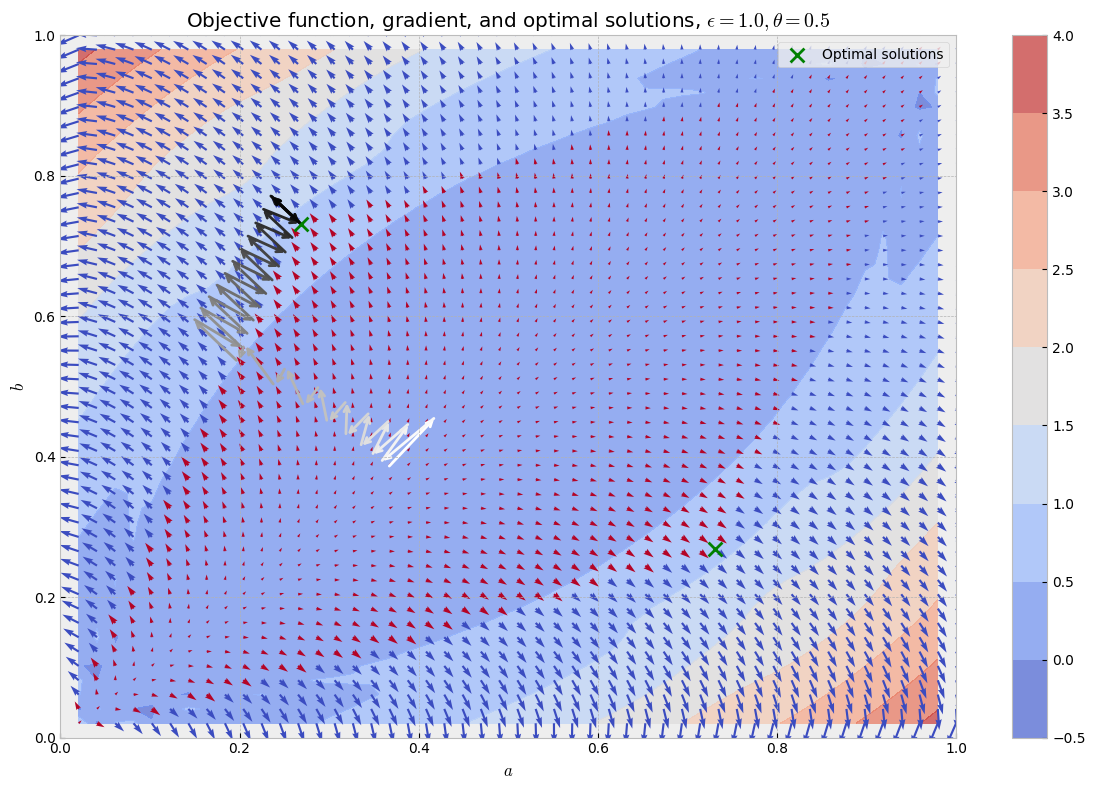

In [26]:
def logsumexp(x, x_prime, epsilon, sigma=1e-1):
    return -sigma * np.log(
        np.exp(-(x/x_prime - np.exp(-epsilon))**2/sigma) +
        np.exp(-(x/x_prime - 1)**2/sigma) +
        np.exp(-(x/x_prime - np.exp(epsilon)**2/sigma))
    )

def logsumexpderiv(x, x_prime, epsilon, sigma=1e-1):
    return -sigma / logsumexp(x, x_prime, epsilon, sigma) * (
        -2/(sigma*x_prime) * (x/x_prime - np.exp(-epsilon)) * np.exp(-(x/x_prime - np.exp(-epsilon))**2/sigma) +
        -2/(sigma*x_prime) * (x/x_prime - 1) * np.exp(-(x/x_prime - 1)**2/sigma) +
        -2/(sigma*x_prime) * (x/x_prime - np.exp(epsilon)) * np.exp(-(x/x_prime - np.exp(epsilon))**2/sigma)
    )

def fisher_gradient_modified(p_theta, p_theta_dot, q_mat, epsilon):
    grad = np.zeros(shape=q_mat.shape)

    long_coef = np.exp(-epsilon) + np.exp(epsilon) + 1
    for i in range(q_mat.shape[0]):
        for j in range(q_mat.shape[1]):
            qpdot = q_mat[i] @ p_theta_dot
            qp = q_mat[i] @ p_theta
            qpdot2 = qpdot**2
            qp2 = qp**2

            first = 2*p_theta_dot[j]*qpdot/qp
            second = p_theta[j]*qpdot2/qp2

            boundary_terms = 0
            for j_prime in range(q_mat.shape[1]):
                if j != j_prime:
                    y = q_mat[i,j]
                    x = q_mat[i,j_prime]
                    boundary_terms += logsumexp(y, x, epsilon, sigma=1)
            grad[i, j] = first - second - 0.1 * boundary_terms
    return grad


def fisher_information_privatized_modified(Q, n, theta, eps):
    p_theta = binom.pmf(np.arange(n + 1), n, theta)
    p_theta_dot = [binom_derivative(i, n, theta) for i in range(n + 1)]

    numerator = np.power(Q @ p_theta_dot, 2)
    denominator = Q @ p_theta
    boundary_terms = 0
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            for j_prime in range(Q.shape[1]):
                if j != j_prime:
                    y = Q[i, j]
                    x = Q[i, j_prime]
                    boundary_terms += logsumexpderiv(y, x, eps, sigma=1)
    return np.sum(numerator / denominator) - 0.1 * boundary_terms


def projected_gradient_ascent_modified(Q_init, p_theta, p_theta_dot, n, theta, epsilon):
    history = [Q_init]
    grads = list()
    fish = fisher_information_privatized_modified(Q_init, n, theta, epsilon)
    q = Q_init

    for i in range(100):
        grad_I = fisher_gradient_modified(p_theta, p_theta_dot, q, epsilon)
        # grad_I = grad_I / np.max(grad_I)
        #grad_I[-1, :] = 0
        q_raw = q + grad_I / np.sqrt(100*(i + 1))
        
        if is_epsilon_private(q_raw, epsilon):
            q_new = q_raw
        else:
            history.append(q_raw)
            q_new = project_onto_feasible_set(q_raw, epsilon)

        fish_next = fisher_information_privatized_modified(q_new, n, theta, epsilon)

        if np.allclose(q, q_new):
            status = f"Converged after {i+1} iterations."
            break

        if abs(fish - fish_next) < 1e-6:
            status = f"Converged after {i+1} iteratons."
            break
        
        q = q_new
        fish = fish_next

        grads.append(grad_I)
        history.append(q)
        status = "Not converged"

    print(status)
    return history, grads

N = 1
THETA = 0.5
EPSILON = 1.0
NVALS = 50

p_theta = binom.pmf(np.arange(N + 1), N, THETA)
p_theta_dot = np.array([binom_derivative(i, N, THETA) for i in range(N + 1)])

a_vals = np.linspace(0, 1, NVALS)
b_vals = np.linspace(0, 1, NVALS)

grads_a = list()
grads_b = list()
private = list()
fishers = list()

for a in a_vals:
    for b in b_vals:
        q_mat = np.array([[a, b], [1-a, 1-b]])
        grad = fisher_gradient_modified(p_theta, p_theta_dot, q_mat, EPSILON)

        fishers.append(fisher_information_privatized_modified(q_mat, N, THETA, EPSILON))
        private.append(is_epsilon_private(q_mat, EPSILON))

        grads_a.append(grad[0, 0])
        grads_b.append(grad[0, 1])

grads_a = np.array(grads_a).reshape((NVALS, NVALS), order="F")
grads_b = np.array(grads_b).reshape((NVALS, NVALS), order="F")
private = np.array(private).reshape((NVALS, NVALS), order="F")
fishers = np.array(fishers).reshape((NVALS, NVALS), order="F")

opt_solutions, _, _ = binom_optimal_privacy(LinearSolver(), N, EPSILON, THETA)
xs = opt_solutions[:, 0]
ys = opt_solutions[:, 1]

Q_init = np.ones((N + 1, N + 1)) / (N + 1) + np.random.normal(size=(N+1, N+1), scale=0.1)
Q_init = project_onto_feasible_set(Q_init, EPSILON)
history, grads = projected_gradient_ascent_modified(Q_init, p_theta, p_theta_dot, N, THETA, EPSILON)
all_history = np.array(history)

colors = plt.cm.binary(np.linspace(0, 1, len(all_history)))

fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.7)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, private, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
#plt.scatter(all_history[:,0,0], all_history[:,0,1], marker="x", s=100, label="Sample path", c=colors)
for i in range(len(all_history) - 1):
    arrow = FancyArrowPatch((all_history[i,0,0], all_history[i,0,1]), (all_history[i+1,0,0], all_history[i+1,0,1]), 
                             color=colors[i], arrowstyle='->', mutation_scale=10, linewidth=2)
    ax.add_patch(arrow)
plt.legend()
plt.title(fr"Objective function, gradient, and optimal solutions, $\epsilon = {EPSILON}, \theta = {THETA}$")
plt.tight_layout()
plt.show()

## Edge traversal

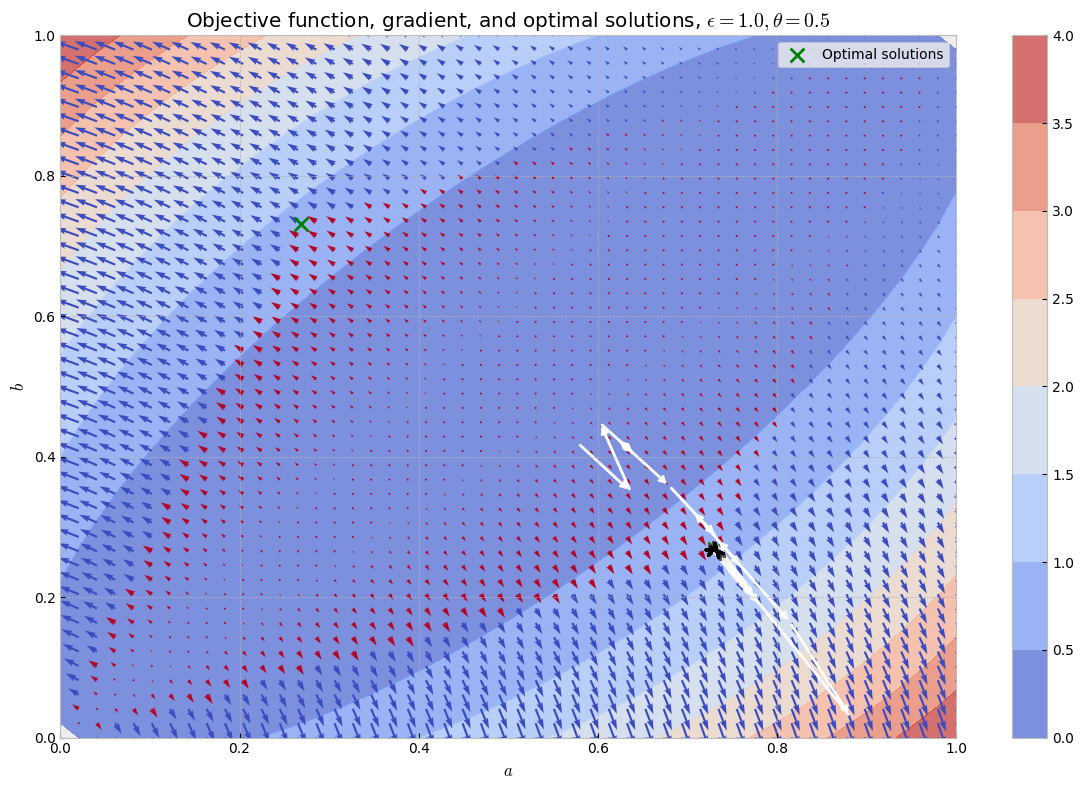

In [3]:
from DP.utils import binom_optimal_privacy
from DP.pga_with_edge_traversal import PGAWithEdgeTraversal

N = 1
THETA = 0.5
EPSILON = 1.0

p_theta = binom.pmf(np.arange(N + 1), N, THETA)
p_theta_dot = np.array([binom_derivative(i, N, THETA) for i in range(N + 1)])

a_vals = np.linspace(0, 1, NVALS)
b_vals = np.linspace(0, 1, NVALS)

grads_a = list()
grads_b = list()
private = list()
fishers = list()

for a in a_vals:
    for b in b_vals:
        q_mat = np.array([[a, b], [1-a, 1-b]])
        grad = fisher_gradient(p_theta, p_theta_dot, q_mat)

        fishers.append(fisher_information_privatized(q_mat, N, THETA))
        private.append(is_epsilon_private(q_mat, EPSILON))

        grads_a.append(grad[0, 0])
        grads_b.append(grad[0, 1])

grads_a = np.array(grads_a).reshape((NVALS, NVALS), order="F")
grads_b = np.array(grads_b).reshape((NVALS, NVALS), order="F")
private = np.array(private).reshape((NVALS, NVALS), order="F")
fishers = np.array(fishers).reshape((NVALS, NVALS), order="F")

opt_solutions, _, _ = binom_optimal_privacy(LinearSolver(), N, EPSILON, THETA)
xs = opt_solutions[:, 0]
ys = opt_solutions[:, 1]


_, _, history = binom_optimal_privacy(PGAWithEdgeTraversal(), N, EPSILON, THETA)

all_history = np.array(history)

colors = plt.cm.binary(np.linspace(0, 1, len(all_history)))

fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.7)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, private, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
#plt.scatter(all_history[:,0,0], all_history[:,0,1], marker="x", s=100, label="Sample path", c=colors)
for i in range(len(all_history) - 1):
    arrow = FancyArrowPatch((all_history[i,0,0], all_history[i,0,1]), (all_history[i+1,0,0], all_history[i+1,0,1]), 
                             color=colors[i], arrowstyle='->', mutation_scale=10, linewidth=2)
    ax.add_patch(arrow)
plt.legend()
plt.title(fr"Objective function, gradient, and optimal solutions, $\epsilon = {EPSILON}, \theta = {THETA}$")
plt.tight_layout()
plt.show()

## 3D plots

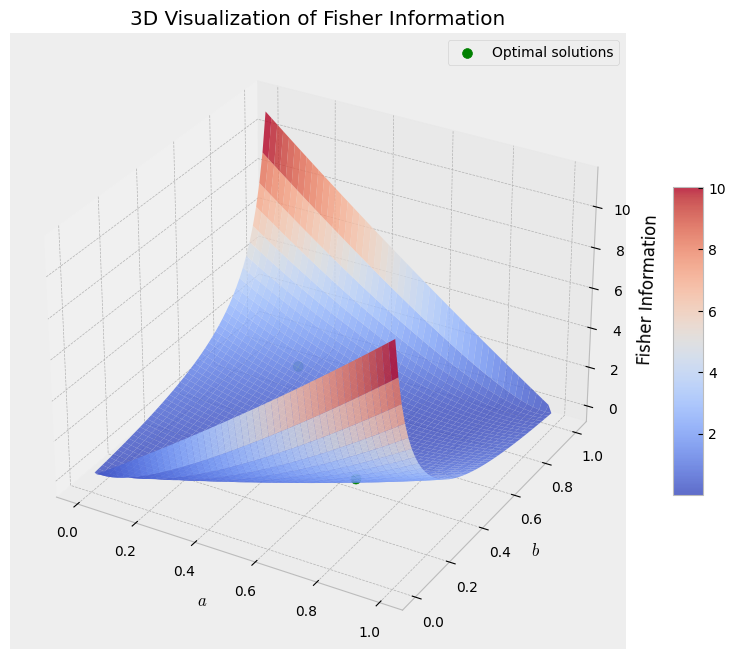

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot of Fisher Information
X, Y = np.meshgrid(a_vals, b_vals)
Z = fishers

surf = ax.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.8)

# Scatter optimal solutions on the surface
ax.scatter(xs, ys, np.interp(xs, a_vals, np.mean(Z, axis=0)), color="green", label="Optimal solutions", s=50)

ax.set_xlabel("$a$")
ax.set_ylabel("$b$")
ax.set_zlabel("Fisher Information")
ax.set_title("3D Visualization of Fisher Information")
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.legend()
plt.show()


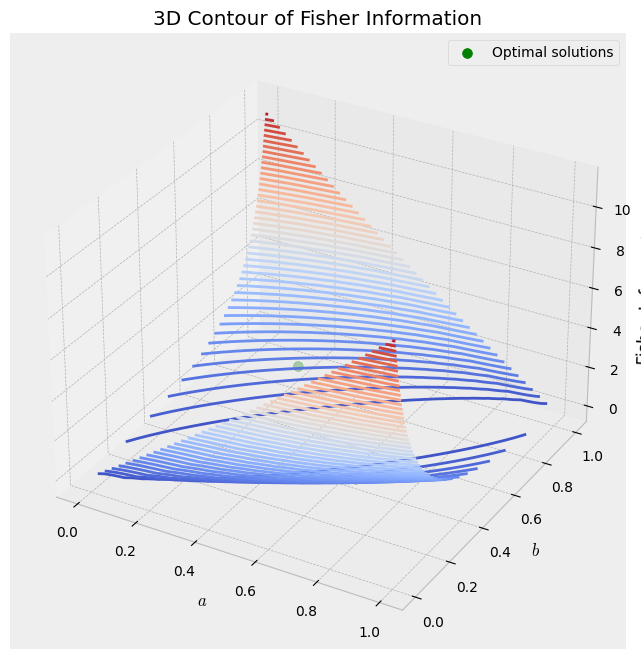

In [29]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create contour plot
X, Y = np.meshgrid(a_vals, b_vals)
Z = fishers
ax.contour3D(X, Y, Z, levels=50, cmap='coolwarm')

# Scatter optimal solutions
ax.scatter(xs, ys, np.interp(xs, a_vals, np.mean(Z, axis=0)), color="green", label="Optimal solutions", s=50)

ax.set_xlabel("$a$")
ax.set_ylabel("$b$")
ax.set_zlabel("Fisher Information")
ax.set_title("3D Contour of Fisher Information")
plt.legend()
plt.show()


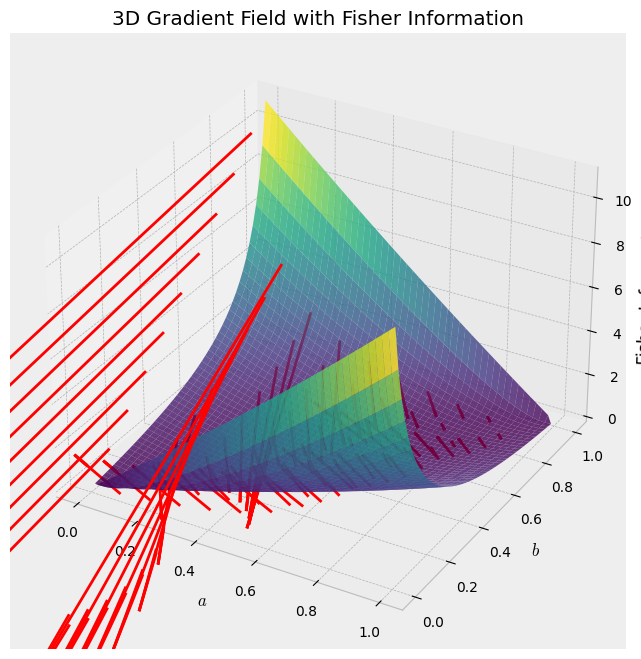

In [30]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot feasible region using Fisher Information as height
X, Y = np.meshgrid(a_vals, b_vals)
Z = fishers
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)

# Add gradient arrows
skip = 5  # To avoid overcrowding arrows
for i in range(0, grads_a.shape[0], skip):
    for j in range(0, grads_a.shape[1], skip):
        ax.quiver(
            a_vals[i], b_vals[j], Z[i, j],
            grads_a[i, j], grads_b[i, j], 0,
            length=0.1, color='red'
        )

ax.set_xlabel("$a$")
ax.set_ylabel("$b$")
ax.set_zlabel("Fisher Information")
ax.set_title("3D Gradient Field with Fisher Information")
plt.show()


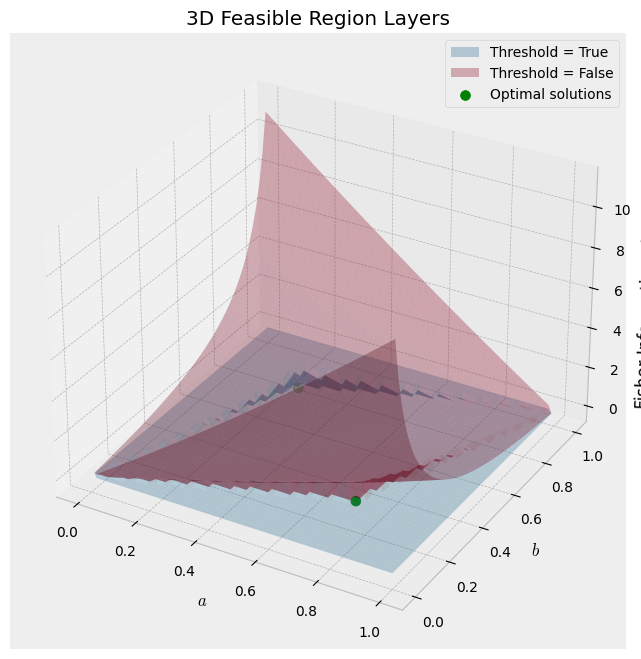

In [31]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Stack layers for different thresholds
for item in [True, False]:
    mask = private == item
    ax.plot_surface(X, Y, mask * fishers, alpha=0.3, label=f"Threshold = {item}")

# Optimal solutions
ax.scatter(xs, ys, np.zeros_like(xs), color="green", label="Optimal solutions", s=50)

ax.set_xlabel("$a$")
ax.set_ylabel("$b$")
ax.set_zlabel("Fisher Information Threshold")
ax.set_title("3D Feasible Region Layers")
plt.legend()
plt.show()


In [32]:
N = 2
THETA = 0.5
EPSILON = 0.5
NVALS = 30

p_theta = binom.pmf(np.arange(N + 1), N, THETA)
p_theta_dot = np.array([binom_derivative(i, N, THETA) for i in range(N + 1)])

a_vals = np.linspace(0, 1, NVALS)
b_vals = np.linspace(0, 1, NVALS)
c_vals = np.linspace(0, 1, NVALS)

grads_a = list()
grads_b = list()
grads_c = list()
private = list()

for a in a_vals:
    d_vals = np.linspace(a, 1, 15)
    for b in b_vals:
        e_vals = np.linspace(b, 1, 15)
        for c in c_vals:
            f_vals = np.linspace(c, 1, 15)
            intermediate_privates = list()
            for d in d_vals:
                for e in e_vals:
                    for f in f_vals:
                        q = np.array([[a, b, c], [d, e, f], [1 - a - d, 1 - b - e, 1 - c - f]])
                        intermediate_privates.append(is_epsilon_private(q, EPSILON))

            grad = fisher_gradient(p_theta, p_theta_dot, q)
            private.append(bool(np.any(intermediate_privates)))

            grads_a.append(grad[0, 0])
            grads_b.append(grad[0, 1])
            grads_c.append(grad[0, 2])

grads_a = np.array(grads_a).reshape((NVALS, NVALS, NVALS), order="F")
grads_b = np.array(grads_b).reshape((NVALS, NVALS, NVALS), order="F")
grads_c = np.array(grads_c).reshape((NVALS, NVALS, NVALS), order="F")
private = np.array(private).reshape((NVALS, NVALS, NVALS), order="F")

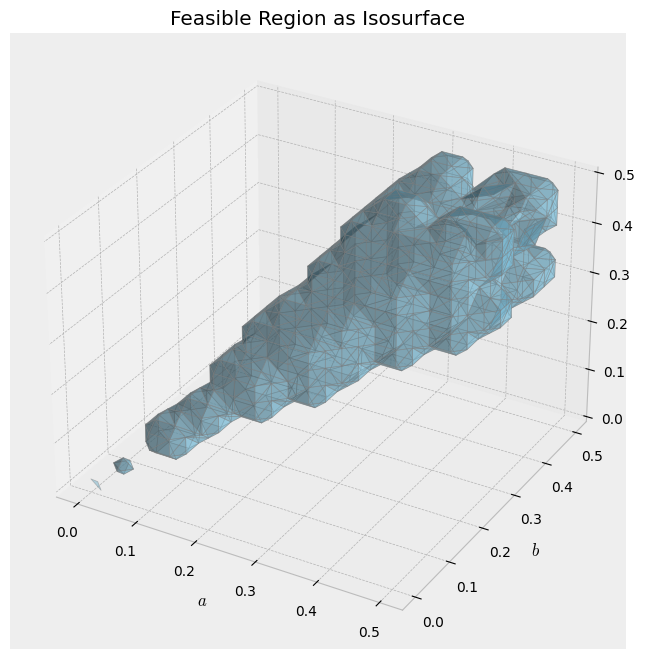

In [33]:
from skimage import measure

# Create a volume grid
a_grid, b_grid, c_grid = np.meshgrid(a_vals, b_vals, c_vals, indexing="ij")

# Generate isosurface for feasible region (private == 1)
verts, faces, _, _ = measure.marching_cubes(private.astype(float), level=0.5)

# Plot the isosurface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Transform vertices back to original scale
verts[:, 0] = verts[:, 0] * (a_vals[-1] - a_vals[0]) / (NVALS - 1) + a_vals[0]
verts[:, 1] = verts[:, 1] * (b_vals[-1] - b_vals[0]) / (NVALS - 1) + b_vals[0]
verts[:, 2] = verts[:, 2] * (c_vals[-1] - c_vals[0]) / (NVALS - 1) + c_vals[0]

# Plot the surface
ax.plot_trisurf(
    verts[:, 0], verts[:, 1], verts[:, 2],
    triangles=faces, color="skyblue", alpha=0.5, edgecolor="gray"
)

ax.set_xlabel("$a$")
ax.set_ylabel("$b$")
ax.set_zlabel("$c$")
ax.set_title("Feasible Region as Isosurface")
plt.show()

In [34]:
import plotly.graph_objects as go

# Extract feasible points
feasible_indices = np.where(private)
feasible_a = a_vals[feasible_indices[0]]
feasible_b = b_vals[feasible_indices[1]]
feasible_c = c_vals[feasible_indices[2]]

# Create the 3D scatter plot
fig = go.Figure()

# Add feasible points
fig.add_trace(go.Scatter3d(
    x=feasible_a,
    y=feasible_b,
    z=feasible_c,
    mode='markers',
    marker=dict(
        size=3,
        color=feasible_c,  # Color by the `c` dimension
        colorscale='Viridis',  # Color scale
        opacity=0.8
    ),
    name='Feasible Points'
))

# Update layout for better visualization
fig.update_layout(
    title="Interactive 3D Feasible Region",
    scene=dict(
        xaxis_title="a",
        yaxis_title="b",
        zaxis_title="c"
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the plot
fig.show()

In [35]:
N = 2
THETA = 0.5
EPSILON = 1.0
NVALS = 100

p_theta = binom.pmf(np.arange(N + 1), N, THETA)
p_theta_dot = np.array([binom_derivative(i, N, THETA) for i in range(N + 1)])

a_vals = np.linspace(0, 1, NVALS)
b_vals = np.linspace(0, 1, NVALS)
c_vals = np.linspace(0, 1, NVALS)

grads_a = list()
grads_b = list()
grads_c = list()
private = list()

for a in a_vals:
    for b in b_vals:
        for c in c_vals:
            q = np.array(
                [[a, b, c],
                [1 - a, 1 - b, 1 - c],
                [0, 0, 0]]
            )

            grad = fisher_gradient(p_theta, p_theta_dot, q)
            private.append(is_epsilon_private(q, EPSILON))

            grads_a.append(grad[0, 0])
            grads_b.append(grad[0, 1])
            grads_c.append(grad[0, 2])

grads_a = np.array(grads_a).reshape((NVALS, NVALS, NVALS), order="F")
grads_b = np.array(grads_b).reshape((NVALS, NVALS, NVALS), order="F")
grads_c = np.array(grads_c).reshape((NVALS, NVALS, NVALS), order="F")
private = np.array(private).reshape((NVALS, NVALS, NVALS), order="F")

/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:104: RuntimeWarning:

invalid value encountered in divide

/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:105: RuntimeWarning:

invalid value encountered in divide



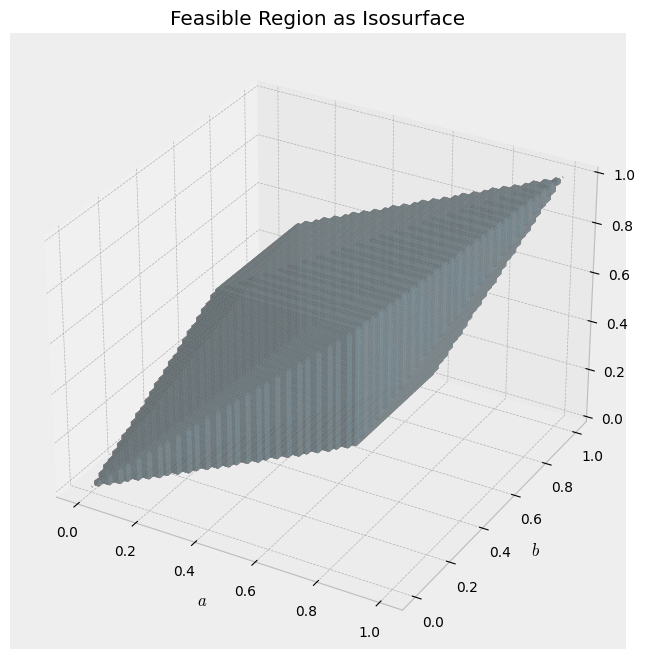

In [36]:
from skimage import measure

# Create a volume grid
a_grid, b_grid, c_grid = np.meshgrid(a_vals, b_vals, c_vals, indexing="ij")

# Generate isosurface for feasible region (private == 1)
verts, faces, _, _ = measure.marching_cubes(private.astype(float), level=0.5)

# Plot the isosurface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Transform vertices back to original scale
verts[:, 0] = verts[:, 0] * (a_vals[-1] - a_vals[0]) / (NVALS - 1) + a_vals[0]
verts[:, 1] = verts[:, 1] * (b_vals[-1] - b_vals[0]) / (NVALS - 1) + b_vals[0]
verts[:, 2] = verts[:, 2] * (c_vals[-1] - c_vals[0]) / (NVALS - 1) + c_vals[0]

# Plot the surface
ax.plot_trisurf(
    verts[:, 0], verts[:, 1], verts[:, 2],
    triangles=faces, color="skyblue", alpha=0.5, edgecolor="gray"
)

ax.set_xlabel("$a$")
ax.set_ylabel("$b$")
ax.set_zlabel("$c$")
ax.set_title("Feasible Region as Isosurface")
plt.show()


In [37]:
from matplotlib.cm import get_cmap

# Assuming `trajectory` is a list of (a, b, c) tuples from gradient ascent
# Example: trajectory = [(a1, b1, c1), (a2, b2, c2), ..., (an, bn, cn)]
trajectory = [el[0] for el in history]
trajectory = np.array(trajectory)  # Convert to a NumPy array for convenience

# Extract individual components of the trajectory
a_traj, b_traj, c_traj = trajectory[:, 0], trajectory[:, 1], trajectory[:, 2]

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the isosurface as before
ax.plot_trisurf(
    verts[:, 0], verts[:, 1], verts[:, 2],
    triangles=faces, color="skyblue", alpha=0.5, edgecolor="gray"
)

cmap = get_cmap("coolwarm")

# Plot each segment of the trajectory with a different color
for i in range(len(a_traj) - 1):
    # Compute color for this step
    color = cmap(i / (len(a_traj) - 1))  # Normalize step index to [0, 1]
    ax.plot(
        a_traj[i:i + 2], b_traj[i:i + 2], c_traj[i:i + 2], 
        color=color, linewidth=2
    )
    ax.scatter(a_traj[i], b_traj[i], c_traj[i], color=color, s=10)

# Set labels and legend
ax.set_xlabel("$a$")
ax.set_ylabel("$b$")
ax.set_zlabel("$c$")
ax.set_title("Feasible Region with Gradient Ascent Trajectory")
ax.legend()

plt.show()


IndexError: index 2 is out of bounds for axis 1 with size 2

## Feasible set clean visualization

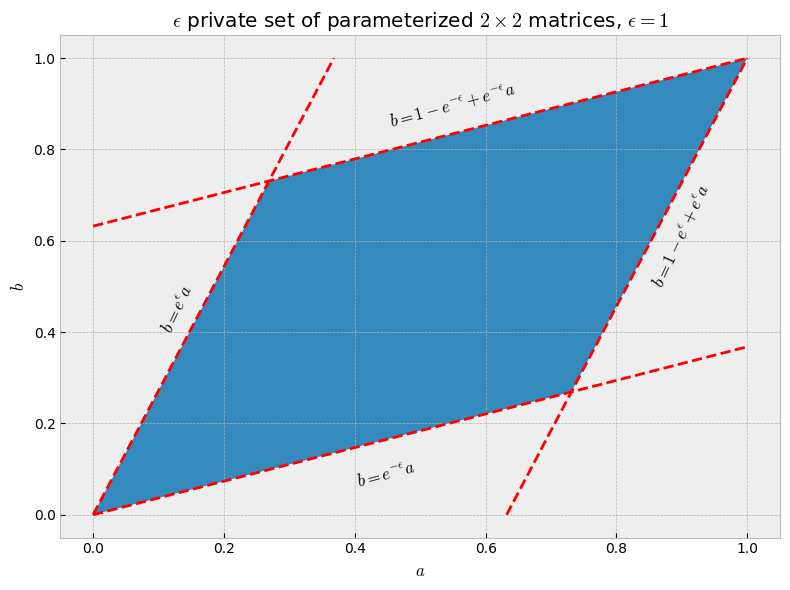

In [8]:
EPSILON = 1

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot([0, np.exp(-EPSILON)], [0, 1], color="red", linestyle="dashed")
ax.plot([0, 1], [0, np.exp(-EPSILON)], color="red", linestyle="dashed")

ax.plot([0, 1], [1 - np.exp(-EPSILON), 1], color="red", linestyle="dashed")
ax.plot([1 - np.exp(-EPSILON), 1], [0, 1], color="red", linestyle="dashed")

ax.fill_between(
    x=[0, (1 - np.exp(-EPSILON)) / (np.exp(EPSILON) - np.exp(-EPSILON)), (1 - np.exp(EPSILON)) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1], 
    y1=[0, (np.exp(EPSILON) - 1) / (np.exp(EPSILON) - np.exp(-EPSILON)), 1 - np.exp(-EPSILON) + (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    y2=[0, (1 - np.exp(-EPSILON)) / (np.exp(2*EPSILON) - 1), (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1]
)

ax.annotate(r"$b = e^\epsilon a$", xy=(0.10, 0.4), fontsize="large", rotation=65)
ax.annotate(r"$b = e^{-\epsilon} a$", xy=(0.4, 0.06), fontsize="large", rotation=15)
ax.annotate(r"$b = 1 - e^{-\epsilon} + e^{-\epsilon}a$", xy=(0.45, 0.85), fontsize="large", rotation=15)
ax.annotate(r"$b = 1 - e^\epsilon + e^\epsilon a$", xy=(0.85, 0.5), fontsize="large", rotation=65)

ax.set_xlabel("$a$")
ax.set_ylabel("$b$")
ax.set_title(r"$\epsilon$ private set of parameterized $2\times 2$ matrices, $\epsilon=1$")

plt.tight_layout()
plt.savefig("figures/epsilon_private_set.png")
plt.show()

/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:104: RuntimeWarning: invalid value encountered in divide
  2 * np.outer(p_theta_dot, Q_ptheta_dot) / Q_ptheta
/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:105: RuntimeWarning: invalid value encountered in divide
  - np.outer(p_theta, Q_ptheta_dot_squared) / Q_ptheta_squared
/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:173: RuntimeWarning: invalid value encountered in divide
  return np.sum(numerator / denominator)
/var/folders/lv/9hw1_pzj1hs5c2glqrzn04m80000gq/T/ipykernel_24554/2733395721.py:38: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.7, label="Fisher information")


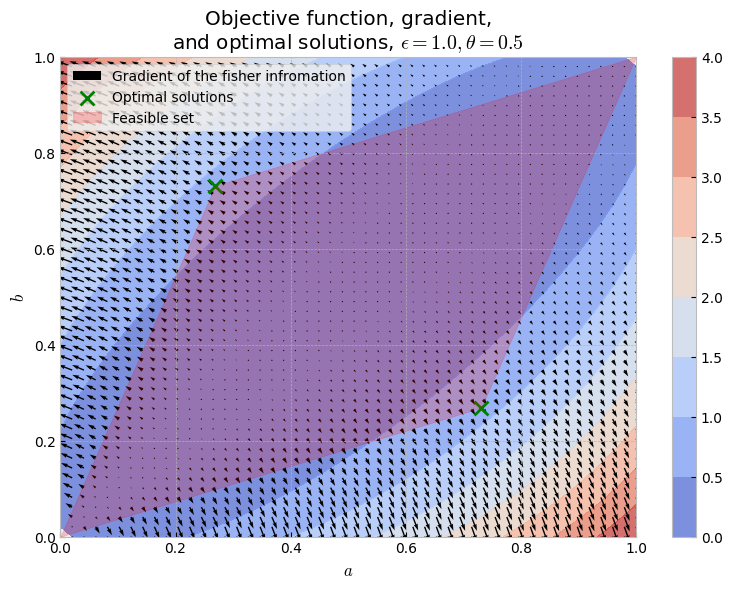

In [23]:
N = 1
THETA = 0.5
EPSILON = 1.0
NVALS = 50

p_theta = binom.pmf(np.arange(N + 1), N, THETA)
p_theta_dot = np.array([binom_derivative(i, N, THETA) for i in range(N + 1)])

a_vals = np.linspace(0, 1, NVALS)
b_vals = np.linspace(0, 1, NVALS)

grads_a = list()
grads_b = list()
fishers = list()

for a in a_vals:
    for b in b_vals:
        q_mat = np.array([[a, b], [1-a, 1-b]])
        grad = fisher_gradient(p_theta, p_theta_dot, q_mat)

        fishers.append(fisher_information_privatized(q_mat, N, THETA))

        grads_a.append(grad[0, 0])
        grads_b.append(grad[0, 1])

grads_a = np.array(grads_a).reshape((NVALS, NVALS), order="F")
grads_b = np.array(grads_b).reshape((NVALS, NVALS), order="F")
fishers = np.array(fishers).reshape((NVALS, NVALS), order="F")

opt_solutions, _, _ = binom_optimal_privacy(LinearSolver(), N, EPSILON, THETA)
xs = opt_solutions[:, 0]
ys = opt_solutions[:, 1]

# Feasible area plot
fig, ax = plt.subplots(figsize=(8, 6))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.7)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)

ax.fill_between(
    x=[0, (1 - np.exp(-EPSILON)) / (np.exp(EPSILON) - np.exp(-EPSILON)), (1 - np.exp(EPSILON)) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1], 
    y1=[0, (np.exp(EPSILON) - 1) / (np.exp(EPSILON) - np.exp(-EPSILON)), 1 - np.exp(-EPSILON) + (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    y2=[0, (1 - np.exp(-EPSILON)) / (np.exp(2*EPSILON) - 1), (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    label="Feasible set",
    color="red",
    alpha=0.2
)

plt.legend()
plt.title("Objective function, gradient,\n" + fr"and optimal solutions, $\epsilon = {EPSILON}, \theta = {THETA}$")
plt.tight_layout()
plt.savefig("figures/objective_function_gradient.png")
plt.show()

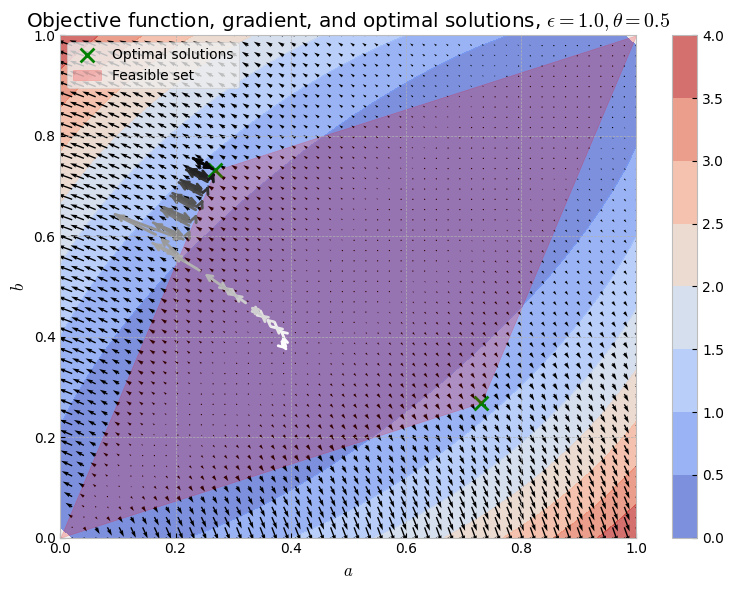

In [26]:
from DP.utils import binom_optimal_privacy
from DP.pga_with_edge_traversal import PGAWithEdgeTraversal

N = 1
THETA = 0.5
EPSILON = 1.0

p_theta = binom.pmf(np.arange(N + 1), N, THETA)
p_theta_dot = np.array([binom_derivative(i, N, THETA) for i in range(N + 1)])

a_vals = np.linspace(0, 1, NVALS)
b_vals = np.linspace(0, 1, NVALS)

grads_a = list()
grads_b = list()
fishers = list()

for a in a_vals:
    for b in b_vals:
        q_mat = np.array([[a, b], [1-a, 1-b]])
        grad = fisher_gradient(p_theta, p_theta_dot, q_mat)

        fishers.append(fisher_information_privatized(q_mat, N, THETA))

        grads_a.append(grad[0, 0])
        grads_b.append(grad[0, 1])

grads_a = np.array(grads_a).reshape((NVALS, NVALS), order="F")
grads_b = np.array(grads_b).reshape((NVALS, NVALS), order="F")
fishers = np.array(fishers).reshape((NVALS, NVALS), order="F")

opt_solutions, _, _ = binom_optimal_privacy(LinearSolver(), N, EPSILON, THETA)
xs = opt_solutions[:, 0]
ys = opt_solutions[:, 1]

_, _, history = binom_optimal_privacy(PGAWithEdgeTraversal(), N, EPSILON, THETA)
all_history = np.array(history)

colors = plt.cm.binary(np.linspace(0, 1, len(all_history)))
fig, ax = plt.subplots(figsize=(8, 6))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.7)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
ax.fill_between(
    x=[0, (1 - np.exp(-EPSILON)) / (np.exp(EPSILON) - np.exp(-EPSILON)), (1 - np.exp(EPSILON)) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1], 
    y1=[0, (np.exp(EPSILON) - 1) / (np.exp(EPSILON) - np.exp(-EPSILON)), 1 - np.exp(-EPSILON) + (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    y2=[0, (1 - np.exp(-EPSILON)) / (np.exp(2*EPSILON) - 1), (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    label="Feasible set",
    color="red",
    alpha=0.2
)
for i in range(len(all_history) - 1):
    arrow = FancyArrowPatch((all_history[i,0,0], all_history[i,0,1]), (all_history[i+1,0,0], all_history[i+1,0,1]), 
                             color=colors[i], arrowstyle='->', mutation_scale=10, linewidth=2)
    ax.add_patch(arrow)
plt.legend()
plt.title(fr"Objective function, gradient, and optimal solutions, $\epsilon = {EPSILON}, \theta = {THETA}$")
plt.tight_layout()
plt.show()